# COVID-19 Detector

[![Twitter Follow](https://img.shields.io/twitter/follow/dialhaseeb?style=social)](www.twitter.com/dialhaseeb)

![Logo](https://github.com/zenyc/zenyc/blob/master/logo-small.png)

## 🕯 About
**covid-19-detector** is a *machine learning model* that predicts if a person has COVID-19 or not by looking at their Lung CT Scan. It uses Deep Learning techniques to do so.

## Before we begin, let's cofigure some stuff so that the notebook runs both on your local machine and on *Google's Colaboratory*

1- If you are running locally, run the following cell:

In [75]:
proj_dir = "proj-dir"

2- If you are running on *Colab*, 
- Make sure you have uploaded all the project files to your *Google Drive*. Then, mount your drive by running the following cell:

In [76]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Then write out the path to the project files relative to your drive's root directory after `/content/drive/My Drive/` in the following cell:

In [77]:
%cd "/content/drive/MyDrive/dataSet/covid-19/Covid_19_lug"

/content/drive/MyDrive/dataSet/covid-19/Covid_19_lug


In [78]:
%ls

COVID_Lung/                          covidVGG16_detector.h5  logs/
COVID_Lung-20210619T073756Z-001.zip  covidVGG16_local.h5


## Next up, let's import everything we need. Run the following:

In [79]:
import os, shutil
import tensorflow
import datetime
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import models

# Jupyter magic command
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Setting up data directory

In [80]:
data_dir = "COVID_Lung/"

In [81]:
os.listdir(data_dir)

['COVID-CT-MetaInfo.xlsx', 'CT_NonCOVID', 'test', 'train', 'CT_COVID']

In [82]:
train_dir = "train"
val_dir = "test"

In [83]:
model = VGG16(
    input_shape=(224,224,3)
)

In [84]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Defining the model:

In [85]:
vgg16_without_head = VGG16(
    # weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

In [86]:
vgg16_without_head.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [87]:
model = models.Sequential()

model.add(vgg16_without_head)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## Uncomment the following if you want to create a custom model instead of using VGG16

In [88]:
layers = tensorflow.keras.layers
models = tensorflow.keras.models
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [89]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)     

In [90]:
## Compiling the model:

In [91]:
optimizers = tensorflow.keras.optimizers
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(),
metrics=['accuracy'])

In [92]:
from tensorflow.keras.preprocessing import image

In [93]:
%pwd

'/content/drive/MyDrive/dataSet/covid-19/Covid_19_lug'

In [94]:
import numpy as np

## Loading Imaes from directory

In [95]:
covids = []
ncovids = []

In [96]:
%pwd

'/content/drive/MyDrive/dataSet/covid-19/Covid_19_lug'

In [97]:
covids_list = os.listdir("COVID_Lung/CT_COVID")
ncovids_list = os.listdir("COVID_Lung/CT_NonCOVID")


In [98]:
covids_list

['2020.02.11.20022053-p12-67_2.png',
 '2020.02.13.20022673-p13-77_1.png',
 '2020.02.13.20022673-p13-77_0.png',
 '2020.02.10.20021584-p6-52_13.png',
 '2020.02.11.20022053-p12-67_1.png',
 '2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89_0.png',
 '2020.02.10.20021584-p6-52_5.png',
 '2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png',
 '2020.01.24.919183-p27-135.png',
 '2020.02.10.20021584-p6-52_11.png',
 '2020.02.10.20021584-p6-52_15.png',
 '2020.02.11.20021493-p16-109_2.png',
 '2020.02.11.20022053-p12-67_3.png',
 '2020.01.24.919183-p27-134.png',
 '2020.02.10.20021584-p6-52_6.png',
 '2020.02.10.20021584-p6-52_7.png',
 '2020.02.10.20021584-p6-52_0.png',
 '2020.02.10.20021584-p6-52_12.png',
 '2020.02.10.20021584-p6-52_10.png',
 '2020.02.11.20021493-p16-109_1.png',
 '2020.01.24.919183-p27-133.png',
 '2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89_1.png',
 '2020.02.11.20022053-p12-67_0.

In [99]:
from tqdm.notebook import tqdm

In [100]:
for file in tqdm(covids_list):
    covids.append(
        image.img_to_array(image.load_img("COVID_Lung/CT_COVID/"+file, target_size=(150,150)))
    )
for file in tqdm(ncovids_list):
    ncovids.append(
        image.img_to_array(image.load_img("COVID_Lung/CT_NonCOVID/"+file, target_size=(150,150)))
    )


In [101]:
covids = np.array(covids)
ncovids = np.array(ncovids)

In [102]:
import pandas as pd

In [103]:
covids_labels = np.array([1]*len(covids))
ncovids_labels = np.array([0]*len(ncovids))

In [104]:
x = np.concatenate([covids, ncovids])

In [105]:
y = np.concatenate([covids_labels, ncovids_labels])

In [106]:
from sklearn.model_selection import train_test_split

In [107]:
x.shape

(746, 150, 150, 3)

In [108]:
y.shape

(746,)

In [109]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=100)

In [110]:
datetime.datetime.now().strftime("%Y-%m-%d-%H%M")

'2021-06-23-0834'

In [111]:
path = "logs/" + datetime.datetime.now().strftime("%Y-%m-%d-%H%M")

In [112]:
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)

In [113]:
history = model.fit(
xtrain,
ytrain,
epochs=20,
validation_split=0.1,
# callbacks=[es]
callbacks=[tensorboard_callback]
)

Epoch 1/20
17/17 [==============================] - 26s 1s/step - loss: 124.5371 - accuracy: 0.4981 - val_loss: 0.6823 - val_accuracy: 0.5000
Epoch 2/20
17/17 [==============================] - 24s 1s/step - loss: 1.1044 - accuracy: 0.5485 - val_loss: 0.8613 - val_accuracy: 0.5000
Epoch 3/20
17/17 [==============================] - 24s 1s/step - loss: 2.8586 - accuracy: 0.5597 - val_loss: 0.6521 - val_accuracy: 0.6000
Epoch 4/20
17/17 [==============================] - 24s 1s/step - loss: 0.6723 - accuracy: 0.6213 - val_loss: 0.6241 - val_accuracy: 0.6167
Epoch 5/20
17/17 [==============================] - 24s 1s/step - loss: 2.0930 - accuracy: 0.5541 - val_loss: 0.6435 - val_accuracy: 0.6333
Epoch 6/20
17/17 [==============================] - 23s 1s/step - loss: 0.6974 - accuracy: 0.6063 - val_loss: 0.6424 - val_accuracy: 0.5333
Epoch 7/20
17/17 [==============================] - 24s 1s/step - loss: 0.7452 - accuracy: 0.5840 - val_loss: 0.6477 - val_accuracy: 0.5167
Epoch 8/20
17/17 [

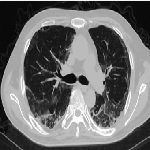

In [114]:
image.array_to_img(xtrain[300])

## With Normalization

In [115]:
xtrain = xtrain/255

In [116]:
xtest = xtest/255

In [117]:
xtrain

array([[[[0.19607843, 0.19607843, 0.19607843],
         [0.19215687, 0.19215687, 0.19215687],
         [0.19607843, 0.19607843, 0.19607843],
         ...,
         [0.2       , 0.2       , 0.2       ],
         [0.20784314, 0.20784314, 0.20784314],
         [0.19607843, 0.19607843, 0.19607843]],

        [[0.19607843, 0.19607843, 0.19607843],
         [0.19215687, 0.19215687, 0.19215687],
         [0.19607843, 0.19607843, 0.19607843],
         ...,
         [0.20784314, 0.20784314, 0.20784314],
         [0.20784314, 0.20784314, 0.20784314],
         [0.1882353 , 0.1882353 , 0.1882353 ]],

        [[0.19607843, 0.19607843, 0.19607843],
         [0.19215687, 0.19215687, 0.19215687],
         [0.19607843, 0.19607843, 0.19607843],
         ...,
         [0.19607843, 0.19607843, 0.19607843],
         [0.21960784, 0.21960784, 0.21960784],
         [0.2       , 0.2       , 0.2       ]],

        ...,

        [[0.24313726, 0.24313726, 0.24313726],
         [0.6392157 , 0.6392157 , 0.6392157 ]

In [118]:
from tensorflow.keras.applications import Xception

In [119]:
xcep = Xception(include_top=False,
               input_shape=(150,150, 3) )

In [120]:
## Setting up Keras `Image Data Generator` for Data Augmentation:

In [121]:
ImageDataGenerator = tensorflow.keras.preprocessing.image.ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, 
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

In [122]:
train_dir
%pwd

'/content/drive/My Drive/dataSet/covid-19/Covid_19_lug'

In [123]:
train_generator = train_datagen.flow_from_directory(
"COVID_Lung/"+train_dir,
target_size=(150, 150),

batch_size=20,
class_mode="binary")

Found 600 images belonging to 2 classes.


In [124]:
validation_generator = val_datagen.flow_from_directory(
"COVID_Lung/"+val_dir,
target_size=(150, 150),
batch_size=2,
class_mode='binary')

Found 146 images belonging to 2 classes.


In [125]:
## Setting up Logs path for Tensorboard:

In [126]:
path = "logs/fit/" + datetime.datetime.now().strftime("%Y-%m-%d-%H%M")

In [127]:
path

'logs/fit/2021-06-23-0842'

## Setting up `Keras Callbacks`:

In [128]:
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)

In [129]:
es = EarlyStopping(monitor='val_loss', mode='min')

## Fitting the model:

In [130]:
history = model.fit(
train_generator,
steps_per_epoch=30, # 30 kahan se aya? 600/20 yani ke training_data_ka_size/batch_size
epochs=6000,
validation_data=validation_generator,
validation_steps=73,
callbacks=[es, tensorboard_callback]
)

Epoch 1/6000
30/30 [==============================] - 38s 1s/step - loss: 0.6781 - accuracy: 0.5917 - val_loss: 0.7384 - val_accuracy: 0.3151


In [131]:
model = models.Sequential()

model.add(xcep)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

optimizers = tensorflow.keras.optimizers
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(),
metrics=['accuracy'])

history = model.fit(
train_datagen,
steps_per_epoch=30, # 30 kahan se aya? 600/20 yani ke training_data_ka_size/batch_size
epochs=6000,
validation_data=validation_generator,
validation_steps=73,
callbacks=[es,tensorboard_callback]
)

ValueError: ignored

In [ ]:
model.save('covidVGG16_detector.h5')

In [ ]:
%tensorboard --logdir logs

## Plotting the history:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(1, len(acc) + 1)

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# The End?